In [10]:
from utils import make_need_tree,visualize_tree,make_storage,make_task_list,calc_start_end_time
import plotly.express as px
import pandas as pd
import json
import random
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import graphviz

In [11]:
storage = make_storage()
storage['fishing net']=20
storage['apple']=20
storage['wool']=20
storage['fish fillet']=100
orders = [
            *['milk']*4,
            *['bread']*3,
            *['cheesecake']*3,
            *['apple pie']*2,
                      ]
tasks=make_task_list(orders,storage)
len(tasks)

118

In [12]:
# orders to count dict
orders_count={}
for order in orders:
    if order in orders_count:
        orders_count[order]+=1
    else:
        orders_count[order]=1

big_dot = graphviz.Digraph()
for order in orders_count:
    tree= make_need_tree(order,orders_count[order])
    dot = visualize_tree(tree)
    big_dot.subgraph(dot)
# add title to the big tree and make it on top
big_dot.render('big_depencies.gv', view=True)

'big_depencies.gv.pdf'

In [13]:
# number of machines
sources={
    'Bakery':1, 'Chicken':2, 'Feed Mill':1, 'Field':6   , 'Raspberry bush':1,'Sugar Mill':1,'Cake Oven':1,
    'Cherry tree':2,'Cow':4,'BBQ Grill':1,'Dairy':1,"Pig":4,'Popcorn Pot':1,'Loom':1,'Sewing Machine':1,
    'Sheep':2,
    'Pie Oven':1,
    'Net Maker':1,
    'Fish':3
}
machines ={}
# make machines is: key is same as sources, value is a list of machine_id
# machine_id must be unique from other machines
count  = 0
for key,value in sources.items():
    machines[key]=list(range(count,count+value))
    count+=value

In [14]:
import random

def make_chromosome(tasks,machines):
    tasks = copy.deepcopy(tasks)
    random.shuffle(tasks)
    tasks.sort(key=lambda x:x['order'],reverse=True)
    for task in tasks:
        machine_id=random.choice(machines[task['source']])
        machine_id=machines[task['source']][0]
        task['machine_id']=machine_id
    return tasks

def calc_fitness(chromosome):
    """calculate the fitness of a chromosome
    chromosome: a chromosome
    
    return: a fitness value
    """
    score = 0
    chromosome = calc_start_end_time(chromosome,machines)
    # maximum end_time
    max_end_time = max([task['end_time'] for task in chromosome])
    score += 10000/max_end_time
    for task in chromosome:
        if task['target']:
            score+=1/task['end_time']
    return score
    
def mutation(chromosome):
    """mutate a chromosome
    chromosome: a chromosome
    
    return: a chromosome
    """
    chromosome = copy.deepcopy(chromosome)
    if random.random()<0.2:
        if random.random()<0.5:
            for i in range(len(chromosome)):
                if random.random()<0.5:
                    gen = chromosome[i]
                    # new_machine_id = random.choice(machines[gen['source']])
                    idx = machines[gen['source']].index(gen['machine_id'])
                    new_machine_id = machines[gen['source']][(idx+1)%len(machines[gen['source']])]
                    gen['machine_id']=new_machine_id
        else:
            gen1,gen2 = random.sample(chromosome,2)
            idx1 = chromosome.index(gen1)
            idx2 = chromosome.index(gen2)
            if idx1>idx2:
                gen1,gen2=gen2,gen1
            if gen1['order']>=gen2['order']:
                chromosome[idx1],chromosome[idx2]=chromosome[idx2],chromosome[idx1]
    return chromosome

def order_crossover(parent1, parent2):
    """
    Perform Order Crossover on two parent chromosomes.

    Args:
    parent1 (list): The first parent chromosome.
    parent2 (list): The second parent chromosome.

    Returns:
    tuple: A tuple containing two new child chromosomes.
    """
    size = len(parent1)
    child1, child2 = [-1] * size, [-1] * size

    # Select a random subsequence from the first parent
    start, end = sorted([random.randint(0, size - 1) for _ in range(2)])
    child1[start:end+1] = parent1[start:end+1]
    child2[start:end+1] = parent2[start:end+1]

    # Fill the remaining positions with genes from the second parent
    fill_remaining(child1, parent2, start, end)
    fill_remaining(child2, parent1, start, end)

    return child1, child2

def fill_remaining(child, parent, start, end):
    """
    Fill the remaining positions in the child chromosome.

    Args:
    child (list): The child chromosome being filled.
    parent (list): The parent chromosome to fill from.
    start (int): The start index of the subsequence.
    end (int): The end index of the subsequence.
    """
    size = len(child)
    p_idx, c_idx = 0, 0

    while -1 in child:
        if parent[p_idx] not in child:
            if c_idx >= start and c_idx <= end:
                c_idx = end + 1
            child[c_idx % size] = parent[p_idx]
            c_idx += 1
        p_idx += 1

def crossover(parent1,parent2):
    parent1 = copy.deepcopy(parent1)
    parent2 = copy.deepcopy(parent2)
    if random.random()<0.2:
        return parent1,parent2
    ids1 = [t['id'] for t in parent1]
    ids2 = [t['id'] for t in parent2]
    child1,child2 = order_crossover(ids1,ids2)
    # replace id with task
    child1 = [parent1[ids1.index(id)] for id in child1]
    child2 = [parent2[ids2.index(id)]  for id in child2]

    # swap machine_id from child1 and child2.
    # loop thourgh child1, find task in child2 with same id
    # swap machine_id
    for task1 in child1:
        if random.random()>0.5:
            task2 = [task for task in child2 if task['id']==task1['id']][0]
            task1['machine_id'],task2['machine_id']=task2['machine_id'],task1['machine_id']
    return child1,child2

In [15]:
def plot_gantt(chromosome,machines):
    test_tasks = calc_start_end_time(chromosome,machines)
    df = pd.DataFrame(test_tasks)
    # task is source + machine_id
    df['task']=df['source']+' '+df['machine_id'].astype(str)
    df['start'] = pd.to_datetime('today')+pd.to_timedelta(df['start_time'],unit='s')
    df['end'] = pd.to_datetime('today')+pd.to_timedelta(df['end_time'],unit='s')
    fig = px.timeline(df, x_start="start", x_end="end", y="task", color="name",hover_name='name', 
                        hover_data={'id':True,'duration':True,'start':False,'end':False,'task':False,'name':False,'source':False,'machine_id':False,'dependencies':True})
    fig.update_yaxes(categoryorder='array',categoryarray=df.sort_values('machine_id')['task'].unique())
    # title is
    return fig

In [16]:
# remove all files
import os
import shutil
shutil.rmtree('ga',ignore_errors=True)
os.makedirs('ga',exist_ok=True)
# simple GA algorithm
pop_size = 10
iteration = 50
fitness_history = []
# generate inital population
population = []
for i in range(pop_size):
    population.append(make_chromosome(tasks,machines))

for i in range(iteration):
    fitness = []
    for chromosome in population:
        fitness.append(calc_fitness(chromosome))
    fitness_history.append(fitness)
    best = max(fitness)
    best_chromosome = population[fitness.index(best)]
    print(f'iteration {i}, best fitness {best}, best time {max([task["end_time"] for task in best_chromosome])}')
    # generate new population
    new_population = [best_chromosome]
    for _ in range(pop_size):
        # select parents
        parent1,parent2 = random.choices(population,weights=fitness,k=2)
        # crossover
        child1,child2 = crossover(parent1,parent2)
        # mutation
        child1 = mutation(child1)
        child2 = mutation(child2)
        new_population.append(child1)
        new_population.append(child2)
    population = new_population
    fig=plot_gantt(best_chromosome,machines)
    fig.update_layout(title_text=f"Iteration {i}, best fitness {best}, best time {max([task['end_time'] for task in best_chromosome])} seconds")
    fig.write_image(f'ga/iteration_{i}.png',width=1500,height=1000)


iteration 0, best fitness 0.11952186988385297, best time 83820
iteration 1, best fitness 0.12187663501172863, best time 82200
iteration 2, best fitness 0.15157372670756364, best time 66120
iteration 3, best fitness 0.15157372670756364, best time 66120
iteration 4, best fitness 0.15157372670756364, best time 66120
iteration 5, best fitness 0.15384157340427146, best time 65160
iteration 6, best fitness 0.15384157340427146, best time 65160
iteration 7, best fitness 0.1592805816160867, best time 62940
iteration 8, best fitness 0.16384388476498457, best time 61200
iteration 9, best fitness 0.16384388476498457, best time 61200
iteration 10, best fitness 0.16384388476498457, best time 61200
iteration 11, best fitness 0.16384388476498457, best time 61200
iteration 12, best fitness 0.16384388476498457, best time 61200
iteration 13, best fitness 0.16384388476498457, best time 61200
iteration 14, best fitness 0.16384388476498457, best time 61200
iteration 15, best fitness 0.16384388476498457, bes

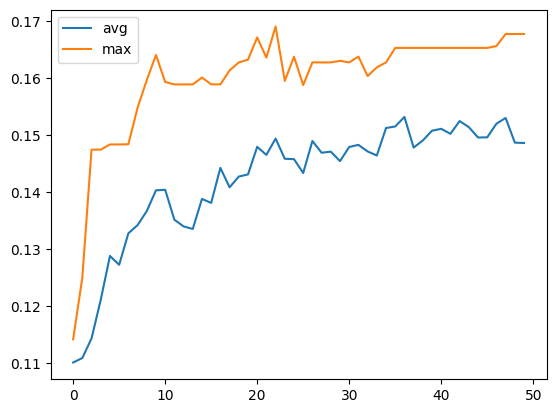

In [ ]:
# plot fitness history, 2 line: average and max fitness
fitness_history = pd.DataFrame(fitness_history)
fitness_history['avg'] = fitness_history.mean(axis=1)
fitness_history['max'] = fitness_history.max(axis=1)
plt.plot(fitness_history['avg'])
plt.plot(fitness_history['max'])
plt.legend(['avg','max'])
plt.show()

In [ ]:
# make gif with images in ga folder
import os
from PIL import Image, ImageSequence
images = []
for i in tqdm(range(iteration)):
    filename = f'ga/iteration_{i}.png'
    images.append(Image.open(filename))
images[0].save('ga.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=250, loop=1)

  0%|          | 0/50 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'ga/iteration_0.png'

In [ ]:
# show gif in notebook loop
from IPython.display import Image
Image(url='ga.gif')